<a href="https://colab.research.google.com/github/fcignoli/Redes-Complejas-2-20222/blob/main/TP_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Librerias necesarias
#!pip install nltk
!pip install PyPDF2

import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import networkx as nx
from PyPDF2 import PdfReader
import re       # libreria de expresiones regulares
import pandas as pd
nltk.download('punkt') # if necessary...
nltk.download("stopwords")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 220 kB 4.3 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# PDF --> Texto --> Limpieza

In [ ]:
def clean_text_round1(text):
    # pasa las mayusculas del texto a minusculas
    text = text.lower()
    # reemplaza texto entre corchetes por espacio en blanco.. ¿ y \% no se..
    text = re.sub('\[.*?¿\]\%', ' ', text)
    # reemplaza singnos de puntuacion por espacio en blanco.. %s -> \S+ es cualquier caracter que no sea un espacio en blanco
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    # remueve palabras que contienen numeros.
    text = re.sub('\w*\d\w*', '', text)
    return text

def clean_text_round2(text):
    # Sacamos comillas, los puntos suspensivos, <<, >>
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('–',"",text)
    text = re.sub('¿',"",text)
    return text

def pdfToText(filepath):
    """
    PDF ---> string
    """
    reader = PdfReader(filepath)
    number_of_pages = len(reader.pages)
    text = ''
    for i in range(number_of_pages):
        text+=reader.pages[i].extract_text()
    """
    Ahora limpiémoslo
    """
    text = clean_text_round1(text)
    text = clean_text_round2(text)
    return text
  

## TO-DO: ***textos*** ---> ***DataFrame***

In [ ]:
import os #para trabajar con la carpeta donde están todos los pdfs
from google.colab import drive
drive.mount('/content/drive')
"""
Link al drive donde subí los ejemplos: https://drive.google.com/drive/folders/1VKAZsJ38SXsidJzHprzUsKXWrakzoZ4H?usp=share_link
"""

"""
función que carga los textos a un dataframe "df" con las columnas texto titulo autor y año
"""
df = pd.DataFrame({"Text":[],
            "Title":[],
            "Author":[],
            "Age":[]},)
def textToDataFrame(texto,titulo,autor,ano):
    return df.append({"Text": texto,
            "Title": titulo,
            "Author": autor,
            "Age": ano},
            ignore_index = True)

"""
La idea ahora es hacer un for loop que camine por nuestros archivos del drive donde están las obras
"""
for root, dirs, files in os.walk("/content/drive/My Drive/Literatura_Argentina"):
    for file in files:
        if file.endswith(".pdf"):
            if len(os.path.join(root, file).split("/")[-1].split("-")) == 3: # si la lista spliteada por '-' es igual a 3, es porque tiene atributo año.
              autor = os.path.join(root, file).split("/")[-1].split("-")[0]
              titulo = os.path.join(root, file).split("/")[-1].split("-")[1]
              ano = os.path.join(root, file).split("/")[-1].split("-")[-1].split(".")[0] #entonces le agregamos el atributo año
            else: # de lo contrario, le ponemos None
              autor = os.path.join(root, file).split("/")[-1].split("-")[0]
              titulo = os.path.join(root, file).split("/")[-1].split("-")[-1].split(".")[0]
              ano = None
            try: 
              texto = pdfToText(os.path.join(root,file))
              df = textToDataFrame(texto,titulo,autor,ano) 
            except:
              print(os.path.join(root,file))
              pass

Mounted at /content/drive
/content/drive/My Drive/Literatura_Argentina/Echeverria, Esteban - El Dogma Socialista De La Juventud Argentina.pdf
/content/drive/My Drive/Literatura_Argentina/Echeverria, Esteban - Himno Al Dolor.pdf
/content/drive/My Drive/Literatura_Argentina/Sarmiento, Domingo F - Argirópolis - 1850.pdf
/content/drive/My Drive/Literatura_Argentina/Sarmiento, Domingo Faustino - Facundo - 1845.pdf


In [ ]:
df

,Text,Title,Author,Age
0,jorge luis borges ficciones el aleph el info...,"Ficciones, El Aleph, El Informe de Brodie",Jorge Luis Borges,None
1,...,La vuelta de Martin Fierro,Jose Hernandez,1879
2,la autopsia de creso ...,La Autopsia De Creso,"Marechal, Leopoldo",1965
3,adolfo bioy casares probablemente fue c...,Noumeno,"Bioy, Casares Adolfo",1965
4,el caso de los viejitos voladores adolfo bioy...,El Caso De Los Viejitos Voladores,"Bioy, Casares Adolfo",1949
5,memoria de paulina adolfo bioy casares ...,En Memoria De Paulina,"Bioy, Casares Adolfo",1942
6,sseeiiss pprroobblleemmaass ppaarraa ...,Seis problemas para don Isidro Parodi,"Bustos, Honorio Domecq",1942
7,digitalizado por srp palabras de lil...,Infierno Grande,"Martinez, Guillermo",1989
8,crímenes imperceptibles sobrecubierta none tag...,Crímenes Imperceptibles,"Martínez, Guillermo",2009
9,don segundo sombra ricardo güiraldes not...,Don segundo sombra,"Guiraldes, Ricardo",1926


# De ***textos*** a ***redes***

In [ ]:
idioma='spanish'
stopwords = nltk.corpus.stopwords.words(idioma)
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words=stopwords)

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

def similitud(copus):
  A=np.empty([len(corpus), len(corpus)])
  for i in np.arange(0,len(corpus),1):
    for j in np.arange(0,len(corpus),1):
      A[i,j]=cosine_sim(corpus[i], corpus[j])
  return A



In [ ]:
#probemos si funciona

text1='Las palabras de De Pedro, en definitiva, comprometen a Massa para que apure la medida que quiere el kirchnerismo y marcan una distancia con Fernández, que viene diciendo -en público y en privado- que no considera apropiado avanzar con un aumento por suma fija. Un efecto similar al que generó ayer Cristina Kirchner cuando cuestionó con dureza el aumento de la medicina prepaga y advirtió, vía Twitter, que “agrava el proceso inflacionario”.'
text2='Con este acuerdo, Moyano ratifica la volatilidad del mapa salarial y confirma que las negociaciones ya se plantean por encima del 100 por ciento. Significa el triple del índice de inflación anual [33%] que proyectó Martín Guzmán en el presupuesto 2022, que no pasó el filtro del Congreso, y un 20% por arriba de la última pauta salarial de referencia que estableció el Estado en su rol de empleador, hace dos meses, cuando pactó una suba de 80% para los trabajadores de YPF.'
text3='Lo que ocurrió fue que mientras el hombre disparaba en la zona de la dirección, profesores y estudiantes bloqueaban las puertas de sus aulas, según señaló el medio puntano La Gaceta Digital. Además, los estudiantes intercambiaban mensajes de audio entre sí sobre los movimientos del atacante que habría realizado también varios disparos al aires antes de encerrarse.'
text4='Angel Di María también está lesionado. Tiene un desgarro leve que lo tendrá inactivo 20 días, según el parte médico de Juventus, que comunicó días atrás: “Lesión de bajo grado en el isquiotibial del muslo derecho. Tardará unos 20 días en recuperarse por completo”. De esta manera, cuenta con margen para recuperarse y llegar con lo justo para el debut en el Mundial Qatar 2022. “Nosotros estamos muy contentos con él; no sólo porque cuando juega, juega bien. Entiende muy bien el juego, es un chico positivo para el grupo”, contó, tiempo atrás, el conductor del equipo nacional.'
text5='A poco más de tres semanas de Qatar, el volante, de 28 años, fue reemplazado por Enrique Fernández, de 19 años. Salió por sus propios medios, pero con evidentes muestras de dolor. Si es un desgarro, llega con lo justo. O no llega, a la cita máxima del fútbol. Es el reemplazante natural de Leandro Paredes, también lesionado, en Juventus, sobre todo cuando el equipo precisa de mayor rigor en la marca, por sobre el manejo natural del jugador surgido en Boca. Rodríguez, está claro, no es uno más para Scaloni.'
text6='The last national defense strategy, published in 2018 by the Trump administration, was the first since the end of the Cold War to refocus U.S. defenses on what it called the twin “revisionist” powers of China and Russia. President Biden’s document builds on that theme but distinguishes between describing China as a “pacing” technological and military challenger, and Russia as an “acute” threat but a declining power.'
text7='Threats from Iran, North Korea and terrorist groups like Al Qaeda and the Islamic State persist — and new challenges, like global climate change, are emerging. But the strategy document focuses heavily on China and Russia.'
text8='In scientific papers published Thursday, scientists using data from two NASA spacecraft reveal that the seismic event was not the cracking of rocks from the internal stresses of the red planet. Instead, it was shock waves emanating from a space rock hitting Mars. The discovery will help scientists better understand what is inside Mars and serves as a reminder that just like Earth, Mars gets whacked by meteors too.'


#cosine_sim('La mesa es roja y grande. La usamos para comer y estudiar. Hay otras mesas en la casa: las mesas de luz, la que esta al lado del baño, la mesita de la tele', 'Existen muchos tipos de mesas en el catalogo. Mesas de comedor, mesas de noche, mesas de jardin, mesas ratonas. Hay mesas que diversos materiales: plastico, madera, metal.')
#print cosine_sim('a little bird', 'a little bird chirps')
#print cosine_sim('a little bird', 'a big dog barks')
cosine_sim(text1,text5) #probemos como funciona

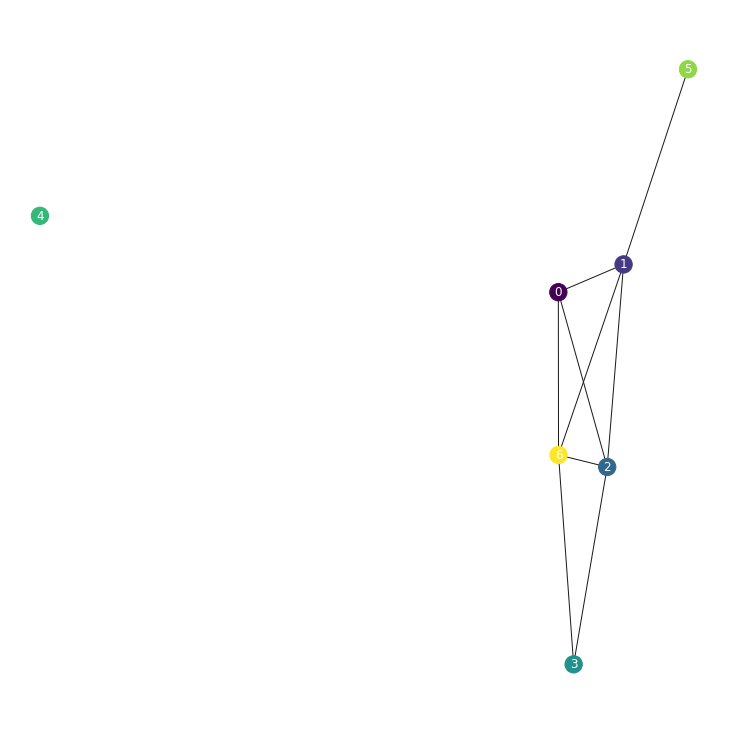

In [ ]:
corpus = [ "El hombre que desembarcó en Buenos Aires en 1871 se llamaba Johannes Dahlmann y era pastor de la Iglesia evangélica; en 1939, uno de sus nietos, Juan Dahlmann, era secretario de una biblioteca municipal en la calle Córdoba y se sentía hondamente argentino. Su abuelo materno había sido aquel Francisco Flores, del 2 de infantería de línea, que murió en la frontera de Buenos Aires, lanceado por indios de Catriel: en la discordia de sus dos linajes, Juan Dahlmann (tal vez a impulso de la sangre germánica) eligió el de ese antepasado romántico, o de muerte romántica. Un estuche con el daguerrotipo de un hombre inexpresivo y barbado, una vieja espada, la dicha y el coraje de ciertas músicas, el hábito de estrofas del Martín Fierro, los años, el desgano y la soledad, fomentaron ese criollismo algo voluntario, pero nunca ostentoso. A costa de algunas privaciones, Dahlmann había logrado salvar el casco de una estancia en el Sur, que fue de los Flores: una de las costumbres de su memoria era la imagen de los eucaliptos balsámicos y de la larga casa rosada que alguna vez fue carmesí. Las tareas y acaso la indolencia lo retenían en la ciudad. Verano tras verano se contentaba con la idea abstracta de posesión y con la certidumbre de que su casa estaba esperándolo, en un sitio preciso de la llanura. En los últimos días de febrero de 1939, algo le aconteció.",
          "Ciego a las culpas, el destino puede ser despiadado con las mínimas distracciones. Dahlmann había conseguido, esa tarde, un ejemplar descabalado de Las Mil y Una Noches de Weil; ávido de examinar ese hallazgo, no esperó que bajara el ascensor y subió con apuro las escaleras; algo en la oscuridad le rozó la frente, ¿un murciélago, un pájaro? En la cara de la mujer que le abrió la puerta vio grabado el horror, y la mano que se pasó por la frente salió roja de sangre. La arista de un batiente recién pintado que alguien se olvidó de cerrar le habría hecho esa herida. Dahlmann logró dormir, pero a la madrugada estaba despierto y desde aquella hora el sabor de todas las cosas fue atroz. La fiebre lo gastó y las ilustraciones de Las Mil y Una Noches sirvieron para decorar pasadillas. Amigos y parientes lo visitaban y con exagerada sonrisa le repetían que lo hallaban muy bien. Dahlmann los oía con una especie de débil estupor y le maravillaba que no supieran que estaba en el infierno. Ocho días pasaron, como ocho siglos. Una tarde, el médico habitual se presentó con un médico nuevo y lo condujeron a un sanatorio de la calle Ecuador, porque era indispensable sacarle una radiografía. Dahlmann, en el coche de plaza que los llevó, pensó que en una habitación que no fuera la suya podría, al fin, dormir. Se sintió feliz y conversador; en cuanto llegó, lo desvistieron; le raparon la cabeza, lo sujetaron con metales a una camilla, lo iluminaron hasta la ceguera y el vértigo, lo auscultaron y un hombre enmascarado le clavó una aguja en el brazo. Se despertó con náuseas, vendado, en una celda que tenía algo de pozo y, en los días y noches que siguieron a la operación pudo entender que apenas había estado, hasta entonces, en un arrabal del infierno. El hielo no dejaba en su boca el menor rastro de frescura. En esos días, Dahlmann minuciosamente se odió; odió su identidad, sus necesidades corporales, su humillación, la barba que le erizaba la cara. Sufrió con estoicismo las curaciones, que eran muy dolorosas, pero cuando el cirujano le dijo que había estado a punto de morir de una septicemia, Dahlmann se echó a llorar, condolido de su destino. Las miserias físicas y la incesante previsión de las malas noches no le habían dejado pensar en algo tan abstracto como la muerte. Otro día, el cirujano le dijo que estaba reponiéndose y que, muy pronto, podría ir a convalecer a la estancia. Increíblemente, el día prometido llegó.",
          "A la realidad le gustan las simetrías y los leves anacronismos; Dahlmann había llegado al sanatorio en un coche de plaza y ahora un coche de plaza lo llevaba a Constitución. La primera frescura del otoño, después de la opresión del verano, era como un símbolo natural de su destino rescatado de la muerte y la fiebre. La ciudad, a las siete de la mañana, no había perdido ese aire de casa vieja que le infunde la noche; las calles eran como largos zaguanes, las plazas como patios. Dahlmann la reconocía con felicidad y con un principio de vértigo; unos segundos antes de que las registraran sus ojos, recordaba las esquinas, las carteleras, las modestas diferencias de Buenos Aires. En la luz amarilla del nuevo día, todas las cosas regresaban a él.",
          "Nadie ignora que el Sur empieza del otro lado de Rivadavia. Dahlmann solía repetir que ello no es una convención y que quien atraviesa esa calle entra en un mundo más antiguo y más firme. Desde el coche buscaba entre la nueva edificación, la ventana de rejas, el llamador, el arco de la puerta, el zaguán, el íntimo patio.",
          "En el hall de la estación advirtió que faltaban treinta minutos. Recordó bruscamente que en un café de la calle Brasil (a pocos metros de la casa de Yrigoyen) había un enorme gato que se dejaba acariciar por la gente, como una divinidad desdeñosa. Entró. Ahí estaba el gato, dormido. Pidió una taza de café, la endulzó lentamente, la probó (ese placer le había sido vedado en la clínica) y pensó, mientras alisaba el negro pelaje, que aquel contacto era ilusorio y que estaban como separados por un cristal, porque el hombre vive en el tiempo, en la sucesión, y el mágico animal, en la actualidad, en la eternidad del instante.",
          "A lo largo del penúltimo andén el tren esperaba. Dahlmann recorrió los vagones y dio con uno casi vacío. Acomodó en la red la valija; cuando los coches arrancaron, la abrió y sacó, tras alguna vacilación, el primer tomo de Las Mil y Una Noches. Viajar con este libro, tan vinculado a la historia de su desdicha, era una afirmación de que esa desdicha había sido anulada y un desafío alegre y secreto a las frustradas fuerzas del mal.",
          "A los lados del tren, la ciudad se desgarraba en suburbios; esta visión y luego la de jardines y quintas demoraron el principio de la lectura. La verdad es que Dahlmann leyó poco; la montaña de piedra imán y el genio que ha jurado matar a su bienhechor eran, quién lo niega, maravillosos, pero no mucho más que la mañana y que el hecho de ser. La felicidad lo distraía de Shahrazad y de sus milagros superfluos; Dahlmann cerraba el libro y se dejaba simplemente vivir."]

text1=corpus[0]
text2=corpus[1]

A=similitud(corpus)

A_filtrada= (A > 0.06).astype(int)-np.identity(len(A))

G = nx.from_numpy_matrix(A_filtrada)
pos = nx.spring_layout(G)
plt.figure(figsize=(10,10))
values=np.linspace(1,100,len(corpus))
nx.draw(G,pos, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True, font_color='white')

## De ***Textos*** a ***Redes*** 
versión Gian

(64016, 13)


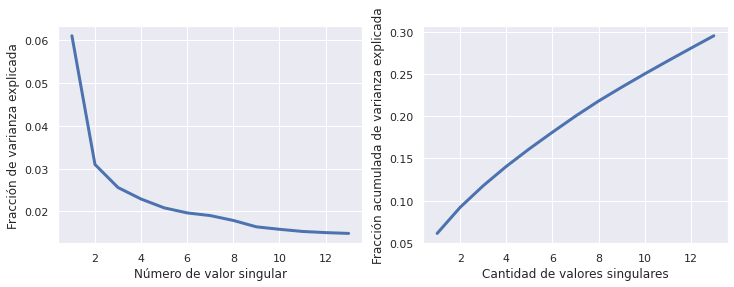

In [ ]:
# Objetos de sklearn para hacer LSA
from sklearn.feature_extraction.text import CountVectorizer # Contador de frecuencia
from sklearn.feature_extraction.text import TfidfTransformer # Creador de tf-idf
from sklearn.decomposition import TruncatedSVD # Singular Value Decomposition
# Lista de stopwords
stopwords = nltk.corpus.stopwords.words('spanish')
from scipy.spatial.distance import cosine as cosine_distance
import heapq
# Creamos el objeto contador de palabras, pidiéndole que remueve
# las stopwords, los términos que aparecen en un único documento (min_df)
# y los términos que aparecen en más del 70% de los documentos (max_df).
# Esto es para eliminar palabras raras (o errores de tipeo) y
# términos que seguramente son stopwords no incluídos en la lista
count = CountVectorizer(min_df = 2, max_df = 0.70, stop_words = stopwords)

# Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
x_count = count.fit_transform(df['Text'])

# Dimensions de la matriz doc-tér
# print(x_count.shape)

# Creamos el objeto tf-idf. Le decimos además que devuelva los
# vectores documento con norma euclídea igual a 1 (norm = 'l2')
tfidf = TfidfTransformer(norm = 'l2')

# Creamos la matriz tf-idf a partir de la matriz de frecuencias
x_tfidf = tfidf.fit_transform(x_count)

# Dimensión del espacio reducido
n_components = 13

# Creación del objeto SVD
svd = TruncatedSVD(n_components = n_components)

# Ajuste con los datos y descripción en el espacio reducido
# Trabajamos con la matriz traspuesta
x_svd = svd.fit_transform(x_tfidf.T)

# Dimensión de la matriz de datos en el espacio reducido
print(x_svd.shape)

# con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
evr = svd.explained_variance_ratio_

# Graficamos la fracción de varianza que aporta cada componente
# y la información acumulada
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '-', linewidth = 3)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de valor singular')

# Calculamos el acumulado con la función cumsum de numpy
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '-', linewidth = 3)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de valores singulares')
plt.show()




In [ ]:
from sklearn.feature_extraction import DictVectorizer

text = list(count.get_feature_names_out())
text


57442

In [ ]:
labels_autores = {}
labels_año = {}
labels_titulo = {}
for i in df.index:
  labels_autores.update({i:df['Author'][i]}) #Creamos un diccionario de índice - autor
  labels_año.update({i:df['Age'][i]})# índice - año
  labels_titulo.update({i:df['Title'][i]})



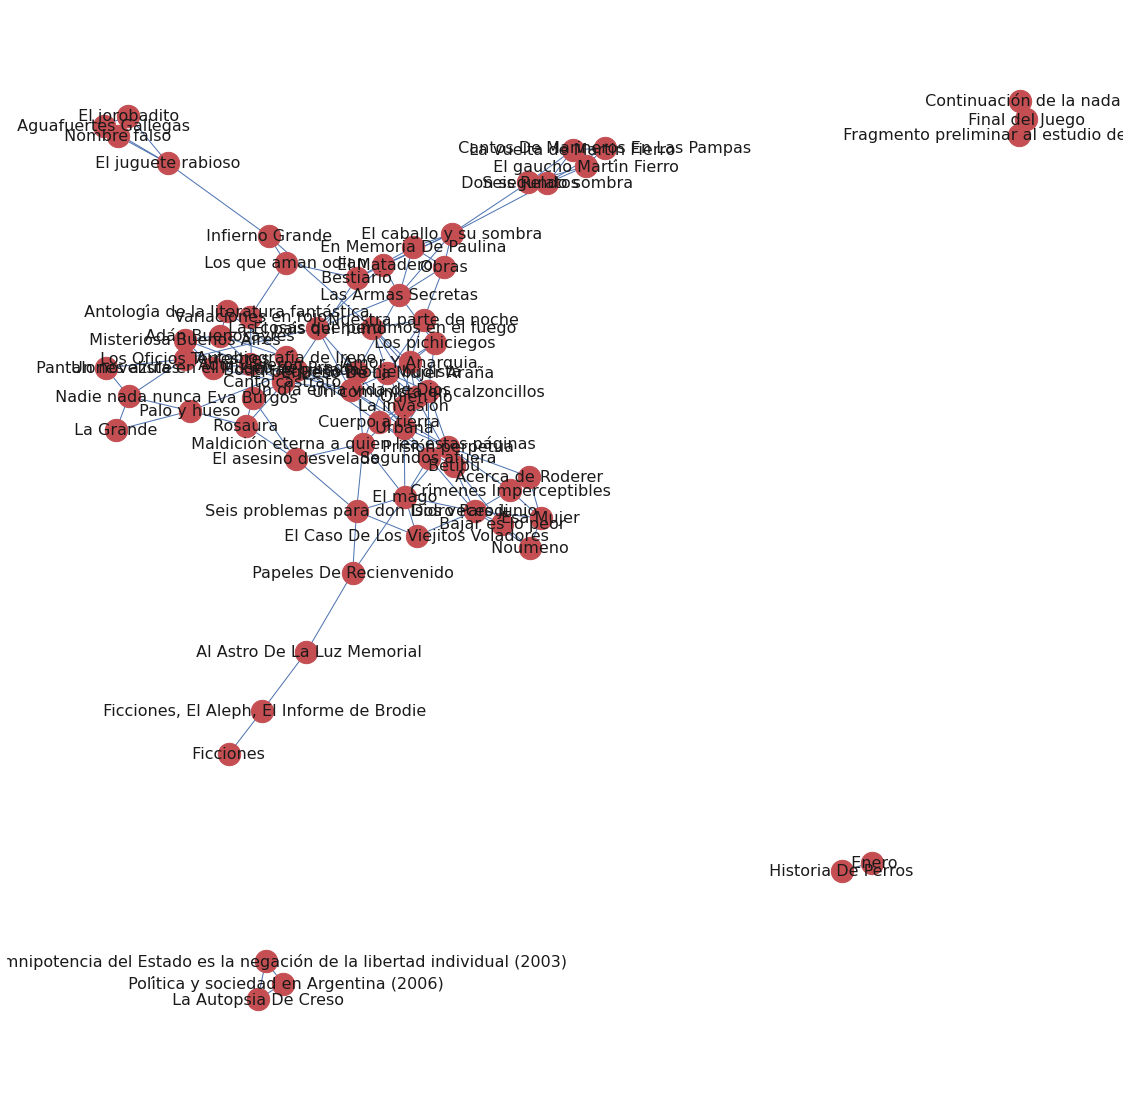

In [ ]:
red = []
for i in df['Text']:
    index = df[df['Text'] == i].index[0]
    similarities = [1.00 - cosine_distance(svd.components_.T[index], svd.components_.T[i]) for i in range(svd.components_.shape[1])]
    red.append(similarities)

matriz = np.array(red)

matriz = (1+matriz)/2
matriz[matriz < .78] = 0 # los que tienen una similaridad menor a 0.8, ledamos 0
matriz[matriz == 1] = 0
matriz[matriz >= .78] = 1 # los que tienen una similaridad mayor a 0.05, le damos 1. de esta manera lo binarizamos

G = nx.from_numpy_matrix(matriz, create_using = nx.Graph)

#pos = nx.layout.fruchterman_reingold_layout(G)

pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize = (20, 20))
ax.axis('off')
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=500)
nx.draw_networkx_edges(G, pos, edge_color='b')
nx.draw_networkx_labels(G, pos, labels_titulo, font_size=16)

#nx.draw(G, with_labels=True)
plt.show()



## Análisis de comunidad

#### Focalicémonos en la red gigante

In [ ]:
componentes= nx.connected_components(G) #tomamos las componentes de la
lista_componentes = [G.subgraph(componente) for componente in 
                     sorted(componentes, key=len, reverse=True)]
G_gigante= lista_componentes[0] #Tomo la componente gigante

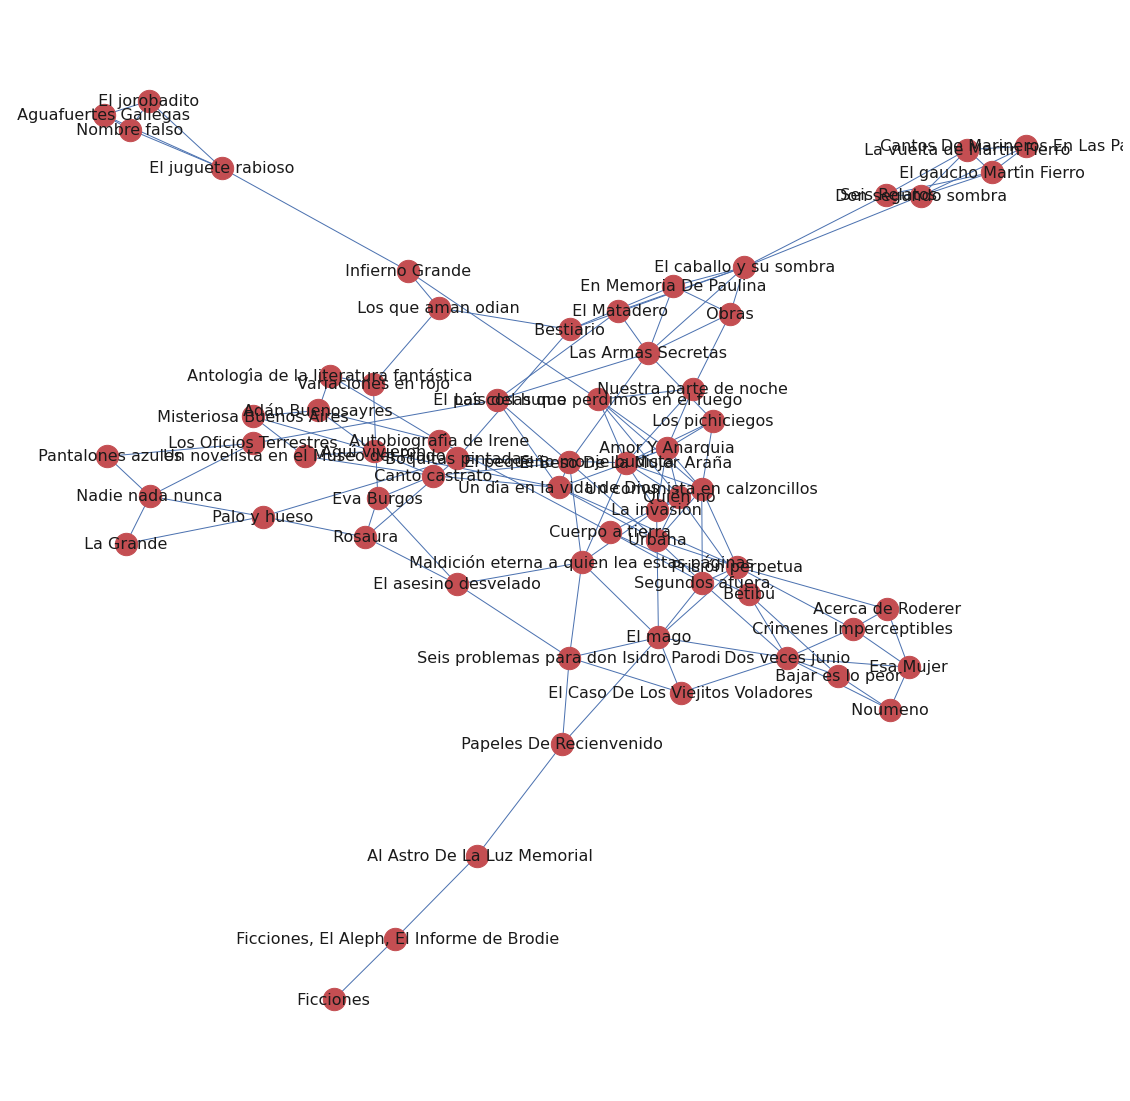

In [ ]:
fig, ax = plt.subplots(figsize = (20, 20))
ax.axis('off')
nx.draw_networkx_nodes(G_gigante, pos, node_color='r', node_size=500)
nx.draw_networkx_edges(G_gigante, pos, edge_color='b')
nx.draw_networkx_labels(G_gigante, pos, labels_titulo, font_size=16)

plt.show()



In [ ]:
!pip install bbox
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo
!pip install igraph
!pip install python-louvain


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
libgif-dev is already the newest version (5.1.4-2ubuntu0.1).
libgif-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libcairo-script-interpreter2 libpixman-1-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc
The following NEW packages will be installed:
  libcairo-script-interpreter2 libcairo2-dev libpixman-1-dev libxcb-shm0-dev
0 upgraded, 4 newly installed, 0 to remove and 5 not upgraded.
Need to get 930 kB of archives.
After this operation, 3,986 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubu

In [ ]:
import igraph as ig
from community import community_louvain as com
import cairo # Importo Cairo
import bbox
# Esto es para que funcione Cairo
from IPython.display import SVG, display, Image
def show_svg(file):
    display(SVG(filename=file))

In [ ]:
# Fastgreedy 

G_ig = ig.Graph.from_networkx(G_gigante)
com_fg = G_ig.community_fastgreedy(weights = None)

In [ ]:
print(com_fg) # Cantidad de elementos y de mergeos hechos
print(f'La cantidad de comunas que maximiza la modularidad es: {com_fg.optimal_count}')
print(f'La modularidad de dicha partición es: {com_fg.as_clustering().modularity}')
print(f'La separación en comunas, considerando 5 comunidades es: \n {com_fg.as_clustering()}')

Dendrogram, 64 elements, 63 merges
La cantidad de comunas que maximiza la modularidad es: 7
La modularidad de dicha partición es: 0.5517010513786946
La separación en comunas, considerando 5 comunidades es: 
 Clustering with 64 elements and 7 clusters
[0] 0, 17, 26, 27
[1] 1, 4, 8, 9, 13, 19, 20, 28, 31
[2] 2, 3, 7, 10, 30, 35, 38, 47, 48, 54, 58, 59, 60, 61, 62, 63
[3] 5, 12, 18, 22, 34, 42, 50, 51, 52, 53, 57
[4] 6, 14, 15, 16, 23, 24, 25, 33, 46
[5] 11, 36, 37, 39, 49
[6] 21, 29, 32, 40, 41, 43, 44, 45, 55, 56


In [ ]:
# Infomap

com_ip = G_ig.community_infomap()

print(com_ip)

Clustering with 64 elements and 10 clusters
[ 0] 0, 17, 26
[ 1] 1, 8, 9, 20, 28
[ 2] 2, 7, 10, 35, 38, 48, 58, 59, 60, 61
[ 3] 3, 5, 18, 27, 51, 54
[ 4] 4, 13, 19, 29, 31, 32, 41, 56
[ 5] 6, 22, 24, 33
[ 6] 11, 30, 36, 37, 39, 47, 49, 62, 63
[ 7] 12, 34, 42, 50, 52, 53, 57
[ 8] 14, 15, 16, 46
[ 9] 21, 23, 25, 40, 43, 44, 45, 55


In [ ]:
# Función para llevar el objeto vertex cluster a diccionario
def cluster_to_dict(cluster, g):
    dic = {}
    for i, c in enumerate(sorted(list(cluster), key = len, reverse = True)):
        for n in c:
            dic[g.vs[n]['_nx_name']] = i
    return dic


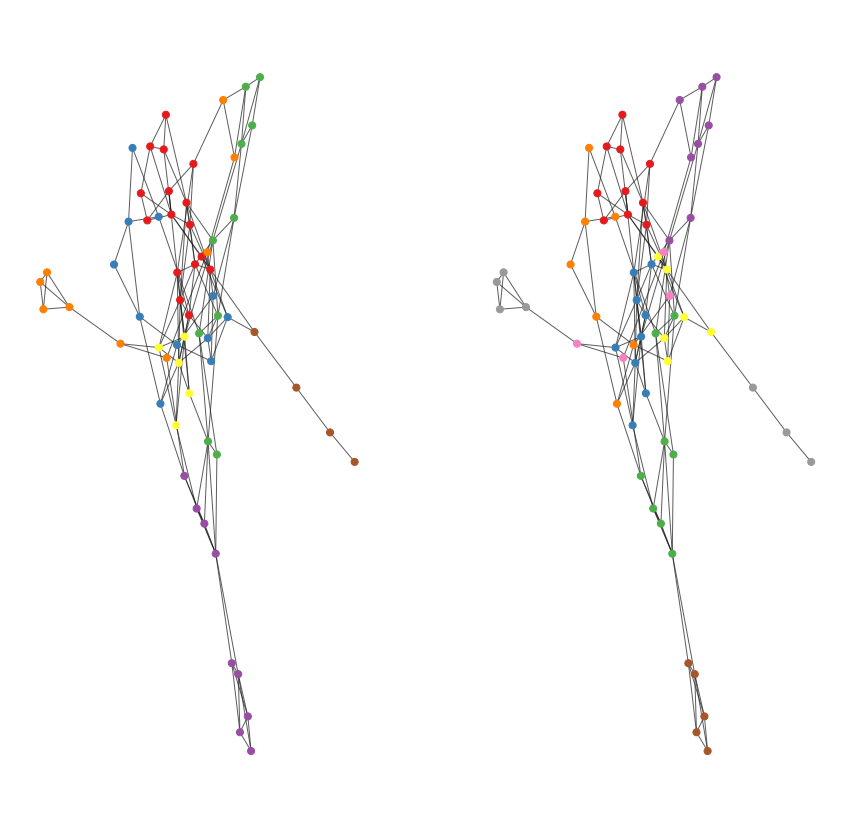

In [ ]:
pos = nx.layout.fruchterman_reingold_layout(G_gigante)

dic_com_fg = cluster_to_dict(com_fg.as_clustering(), G_ig)
dic_com_ip = cluster_to_dict(com_ip, G_ig)
particiones = [dic_com_fg, dic_com_ip]

fig, axs = plt.subplots(1, 2, figsize = (15, 15))

for i, ax in enumerate(fig.axes):
    nx.draw_networkx_nodes(G_gigante,
                           pos = pos,
                           node_color = [plt.get_cmap('Set1')(particiones[i][v]) for v in G_gigante.nodes()],
                           ax = ax,
                           node_size = 50)
    nx.draw_networkx_edges(G_gigante,
                           pos = pos,
                           ax = ax,
                           alpha = .7)
    ax.axis('off')
plt.show()

plt.show()

In [ ]:
dic_com_fg

{3: 0,
 4: 0,
 8: 0,
 11: 0,
 36: 0,
 42: 0,
 45: 0,
 55: 0,
 56: 0,
 62: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 6: 1,
 13: 1,
 20: 1,
 24: 1,
 41: 1,
 50: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 65: 1,
 23: 2,
 35: 2,
 39: 2,
 47: 2,
 48: 2,
 51: 2,
 52: 2,
 53: 2,
 63: 2,
 64: 2,
 1: 3,
 5: 3,
 9: 3,
 10: 3,
 15: 3,
 21: 3,
 22: 3,
 31: 3,
 37: 3,
 7: 4,
 16: 4,
 17: 4,
 18: 4,
 25: 4,
 26: 4,
 27: 4,
 40: 4,
 54: 4,
 12: 5,
 43: 5,
 44: 5,
 46: 5,
 57: 5,
 0: 6,
 19: 6,
 29: 6,
 30: 6}

In [ ]:
#Red Negra que queda piola
pos = nx.spring_layout(G)
fig, ax = plt.subplots(figsize = (50, 40))
ax.axis('off')
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)
nx.draw_networkx_edges(G, pos, edge_color='white')
nx.draw_networkx_labels(G, pos, labels_titulos, font_size=13, font_color='white')
fig.set_facecolor("#00000F")
#nx.draw(G, with_labels=True)
plt.show()